## Relax take-home challenge

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from utils import adopted_user
from visuals import *

%matplotlib inline

In [77]:
data_path = 'D:\\PycharmProjects\\springboard\\exercises\\relax_challenge'
users = pd.read_csv(
    f'{data_path}\\takehome_users.csv',
    encoding='iso-8859-1'
)
engagement = pd.read_csv(f'{data_path}\\takehome_user_engagement.csv')

In [78]:
print(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


In [79]:
print(engagement.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


## Retrieve the adopted user status

In [80]:
# unique number of users
engagement['user_id'].nunique()

8823

In [81]:
# convert time stamp to datetime format
engagement['time_stamp'] = pd.to_datetime(
    engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S'
)

# Create adopted user variable
adopted_idx = engagement.groupby('user_id').apply(adopted_user)
print('Number of adopted users:', sum(adopted_idx))

Number of adopted users: 1656


## Clean and feature engineer

Since the dataset here is old, I will avoid using any current date in the
data set. Nevertheless, we can calculate the time delta between the time
user create the account and the time since their last session. Lets call
this feature time_create_last_session.

A better way to do this would be calculate:
1. account_age = current_time - creation_date
2. time_since_last_login = current_time - last_session_creation_time

In [82]:
# numbers of missing data for each column
users.isnull().sum().sum()

8760

In [83]:
# Remove columns with no useful information from user df
users.drop(
    ['name', 'email', 'object_id', 'invited_by_user_id'],
    axis=1,
    inplace=True
)

In [84]:
# convert unix column to days
users['last_session_creation_time'] = pd.to_datetime(
    users['last_session_creation_time'],
    unit='s'
)

# convert timestamp to datetime
users['creation_time'] = pd.to_datetime(
    users['creation_time'], format='%Y-%m-%d %H:%M:%S'
)

# Create time_create_last_session
users['time_create_last_session'] = users['last_session_creation_time'] - users['creation_time']
users['time_create_last_session'] = pd.to_numeric(users['time_create_last_session'])

# Remove the dates before fitting models
users.drop(['creation_time', 'last_session_creation_time'], axis=1, inplace=True)

In [85]:
# merge the adopted_idx as the predictor to users
users = pd.concat([users, adopted_idx], axis=1, join='inner')
users = users.rename(columns={0: 'adopted_user'})

### EDA

The only 3 columns that can be easily observed are:
1. creation source
2. opted_in_to_mailing_list
3. enabled_for_marketing_drip

Plotting these 3 showed they have a very small effect on the overall
adoption rate. (Notice the percentage is almost the same for each category)

Creation_time can be used along with current time to see if longer
account has any effect on the adoption rate.

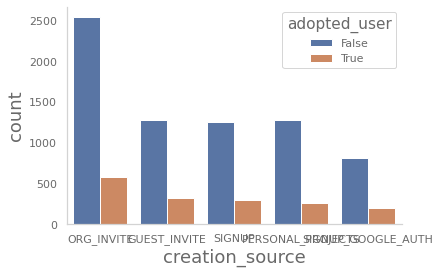

In [92]:
# Creation source
sns.countplot(x='creation_source', hue='adopted_user', data=users)
plt.savefig(f'{data_path}\\image\\creation_source.png')

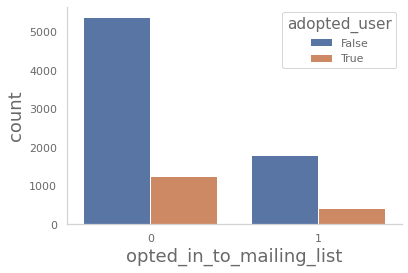

In [93]:
# Creation source
sns.countplot(x='opted_in_to_mailing_list', hue='adopted_user', data=users)
plt.savefig(f'{data_path}\\image\\mail.png')

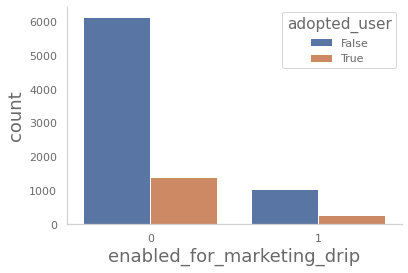

In [94]:
# Creation source
sns.countplot(x='enabled_for_marketing_drip', hue='adopted_user', data=users)
plt.savefig(f'{data_path}\\image\\marketing.png')

## Models

Random forest is the good model choice for this classification problem
since it provides the feature importance that can be useful in the report.

Since this is a quick report, I will refrain from create 3 partitions
for train, validation and test sets. I will set up only train and test
set to get a general view of the most important factors here.

I also transform the creation source to dummy variables. I drop and use
personal projects inside creation source as the baseline for comparison.

In [89]:
# set seed
np.random.seed(25)

# Get X and y
y = users.adopted_user
X = users.drop('adopted_user', axis=1)

# Transform creation source into dummies variable
creation_src_dummy = pd.get_dummies(
    users.creation_source,
    prefix='source_',
    drop_first=True
)
X = pd.concat([X, creation_src_dummy], axis=1)
X = X.drop('creation_source', axis=1)

# split train test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=25, test_size=0.3
)

### Random Forest

In [90]:
# fit and predict
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# print report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.88      0.85      2160
        True       0.18      0.12      0.14       487

    accuracy                           0.74      2647
   macro avg       0.50      0.50      0.49      2647
weighted avg       0.70      0.74      0.72      2647



In [91]:
# print feature importance
pd.Series(clf.feature_importances_, index=X.columns)

opted_in_to_mailing_list      0.008866
enabled_for_marketing_drip    0.007462
org_id                        0.725748
time_create_last_session      0.237597
source__ORG_INVITE            0.006394
source__PERSONAL_PROJECTS     0.004450
source__SIGNUP                0.004886
source__SIGNUP_GOOGLE_AUTH    0.004597
dtype: float64